# Clustering

This notebook covers some basic clustering techniques, which can be used in microbiome science.

If you want to learn more about machine learning I can highly recommend [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) by Hastie, Tibshirani, and Friedman.

# Contents
* [The dataset](#data)
* [Partitioning around mediods](#pam)

## Dataset<a class="anchor" id="data"></a>

Let's load our test dataset

In [1]:
library(phyloseq)
load("../data/physeq.RData")

## PAM clustering<a class="anchor" id="pam"></a>
Partitioning around mediods (PAM) is a k-mediods clustering algorithm often used in microbiome sciences. The algorithm tries to cluster the data into k clusters that are centered around mediods, which are central data points. With PAM clustering you have to choose the number of clusters *a priori*. Therefore, the algorithm is often run across a range of clusters and the quality of clusters are compared to asses how many clusters are optimal for the dataset. The cluster quality is measured by silhoutte width, which is a measure of how close an observation is to other observations in the same cluster compared to its proximity to obsevations in the neighboring cluster. A silhoutte width of 1 means that clusters are well-defined, whereas a silhoutte width of 0 means that clusters are highly overlapping.

### Input data
PAM clutering can be run directly on the abundances in which case dissimilarities are usually calculated by euclidian or manhattan distances. However, for microbiome data these distance metrics are usually biased due to the very skewed, non-normal, and zero-inflated data. Fortunately, PAM clustering can use any dissimilarity matrix as input, and we can therefore use any the commonly used beta diversity metrics.

### In R:

In [2]:
library(cluster)

Calculate weighted UniFrac distances on normalized and transformed abundances:

In [3]:
phy_rel <- transform_sample_counts(phy, function(x) log10(x+1/sum(x+1)))
UF <- UniFrac(phy_rel, weighted = TRUE)

We wrap the PAM clustering in an lapply() in order to run the algorithm with different number of clusters (k):

In [4]:
n_clust <- 2:10
pam_list <- lapply(n_clust, function(x) pam(UF, k = x))

Plot silhoutte width

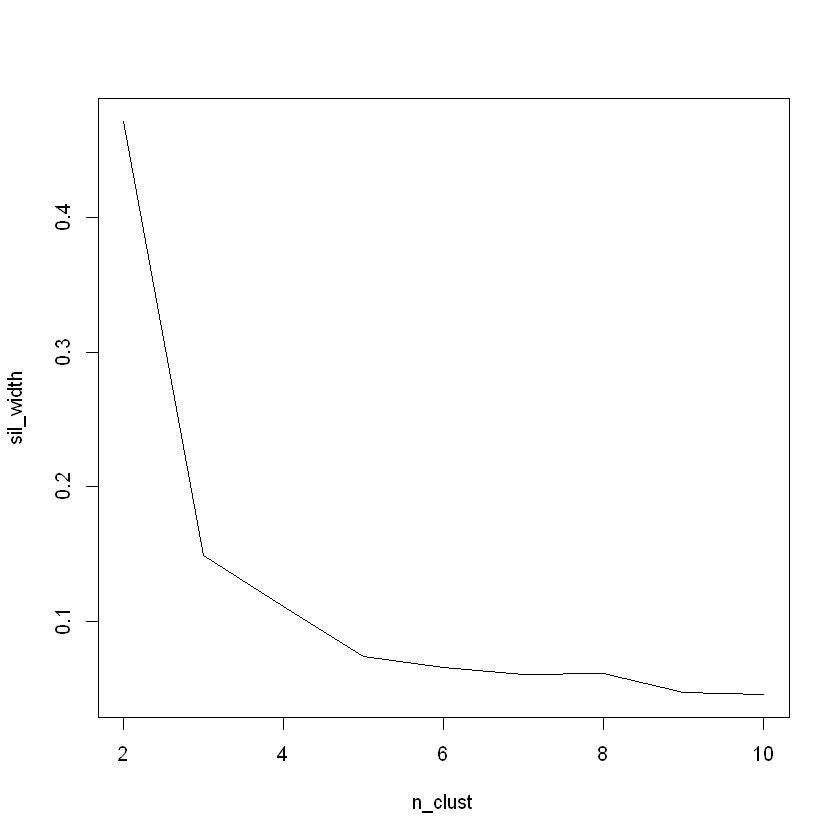

In [5]:
sil_width <- lapply(pam_list, function(x) mean(x$silinfo$widths[, "sil_width"]))
plot(n_clust, sil_width, type="l")

So 2 clusters is the best number of clusters. We cannot calculate silhoutte width for 1 cluster, so with silhoutte width don't know if the dataset can actually be clustered in a sensible way. We should therefore always visualize the data to check that we trust the clusters.

Let's plot a PCoA:

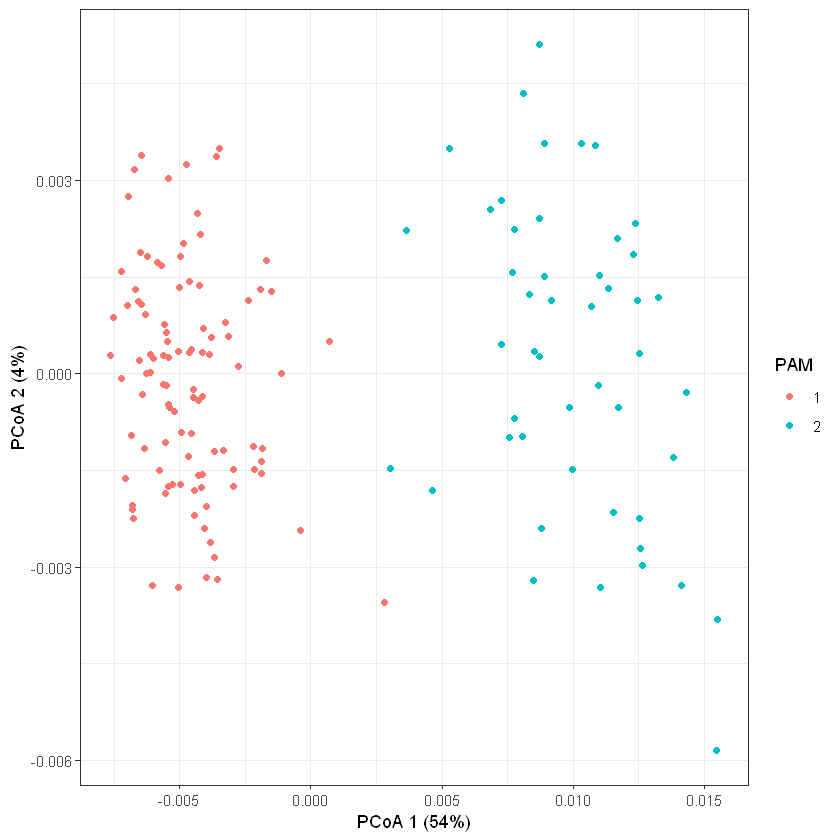

In [6]:
# PCoA
pcoa_data <- cmdscale(UF, eig = TRUE)

# Collect in data.frame
pcoa_df <- data.frame(PC1 = c(pcoa_data$points[,1]),
                      PC2 = c(pcoa_data$points[,2]),
                      Sample = rownames(pcoa_data$points))

# Add sample data
Samp <- data.frame(sample_data(phy))
Samp$Sample <- sample_names(phy)

pcoa_df <- merge(pcoa_df, Samp, by = "Sample")

# Add cluster information
clusters <- factor(pam_list[[which.max(sil_width)]]$clustering)
pcoa_df <- merge(pcoa_df, clusters, by.x = "Sample", by.y = "row.names")
colnames(pcoa_df)[ncol(pcoa_df)] <- "PAM"

# Variance explained
ve <- pcoa_data$eig/sum(pcoa_data$eig)

# Plot
library(ggplot2)
p <- ggplot(pcoa_df, aes(x = PC1, y = PC2, color = PAM)) +
    theme_bw() +
    geom_point() +
    xlab(paste0("PCoA 1 (",round(ve[1]*100,1),"%)")) +
    ylab(paste0("PCoA 2 (",round(ve[2]*100,1),"%)"))
p

Looks sensible. Let's colour by Time and split the plot by PAM cluster:

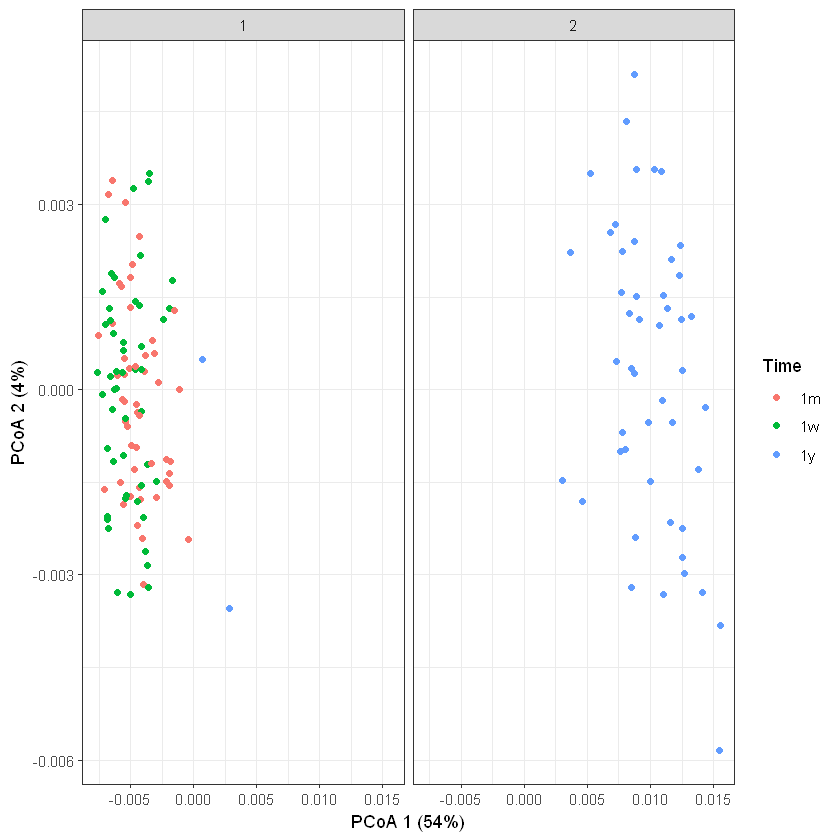

In [7]:
p <- ggplot(pcoa_df, aes(x = PC1, y = PC2, color = Time)) +
    theme_bw() +
    geom_point() +
    xlab(paste0("PCoA 1 (",round(ve[1]*100,1),"%)")) +
    ylab(paste0("PCoA 2 (",round(ve[2]*100,1),"%)")) +
    facet_wrap(~PAM)
p

So our PAM clusters are splitting our samples in early (1 week and 1 month) and late (1 year) clusters, which is as expected.